In [ ]:
import yfinance as yf

def get_stock_data(symbol, period):
    """
    Function to fetch stock data using yfinance.

    Parameters:
        symbol (str): Stock symbol (e.g., "AAPL" for Apple Inc.).
        period (str): Period for which data should be fetched (e.g., "1y" for 1 year).

    Returns:
        pandas.DataFrame: DataFrame containing stock data.
    """
    stock_data = yf.download(symbol, period=period)
    return stock_data

def calculate_sma(data, window):
    """
    Function to calculate the n-day Simple Moving Average (SMA).

    Parameters:
        data (pandas.DataFrame): DataFrame containing stock data.
        window (int): Number of periods to calculate the SMA.

    Returns:
        pandas.Series: Series containing the SMA values.
    """
    sma = data['Close'].rolling(window=window).mean()
    return sma

# Example usage:
symbol = "ITC.NS"  # Example stock symbol (Apple Inc.)
period = "3y"  # Period for which data should be fetched
window = 50  # Number of days for SMA calculation

# Fetch stock data
stock_data = get_stock_data(symbol, period)

# Calculate SMA
sma = calculate_sma(stock_data, window)

print(sma)


[*********************100%%**********************]  1 of 1 completed

Date
2021-05-10           NaN
2021-05-11           NaN
2021-05-12           NaN
2021-05-14           NaN
2021-05-17           NaN
                 ...    
2024-05-06    421.364001
2024-05-07    421.986002
2024-05-08    422.684001
2024-05-09    423.119001
2024-05-10    423.497001
Name: Close, Length: 743, dtype: float64


In [ ]:


def detect_crossovers(data, sma):
    """
    Function to detect crossovers between stock price and SMA.

    Parameters:
        data (pandas.DataFrame): DataFrame containing stock data.
        sma (pandas.Series): Series containing the SMA values.

    Returns:
        dict: Dictionary containing crossover dates and types (from above or from below).
    """
    crossovers = {'from_below': [], 'from_above': []}
    for i in range(1, len(data)):
        if data['Close'][i] > sma[i] and data['Close'][i - 1] <= sma[i - 1]:
            crossovers['from_below'].append(data.index[i])
        elif data['Close'][i] < sma[i] and data['Close'][i - 1] >= sma[i - 1]:
            crossovers['from_above'].append(data.index[i])
    return crossovers


# Detect crossovers
crossovers = detect_crossovers(stock_data, sma)

print("Crossovers from below:", crossovers['from_below'])
print("Crossovers from above:", crossovers['from_above'])


Crossovers from below: [Timestamp('2021-07-23 00:00:00'), Timestamp('2021-08-02 00:00:00'), Timestamp('2021-08-30 00:00:00'), Timestamp('2021-11-08 00:00:00'), Timestamp('2021-11-10 00:00:00'), Timestamp('2021-11-12 00:00:00'), Timestamp('2021-12-09 00:00:00'), Timestamp('2022-01-17 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2022-02-15 00:00:00'), Timestamp('2022-03-04 00:00:00'), Timestamp('2022-06-21 00:00:00'), Timestamp('2022-06-23 00:00:00'), Timestamp('2022-11-24 00:00:00'), Timestamp('2022-11-29 00:00:00'), Timestamp('2022-12-09 00:00:00'), Timestamp('2023-01-23 00:00:00'), Timestamp('2023-08-09 00:00:00'), Timestamp('2023-10-11 00:00:00'), Timestamp('2023-11-15 00:00:00'), Timestamp('2023-12-01 00:00:00'), Timestamp('2024-03-22 00:00:00')]
Crossovers from above: [Timestamp('2021-07-20 00:00:00'), Timestamp('2021-07-29 00:00:00'), Timestamp('2021-08-23 00:00:00'), Timestamp('2021-10-28 00:00:00'), Timestamp('2021-11-09 00:00:00'), Timestamp('2021-11-11 00:00:00'), 

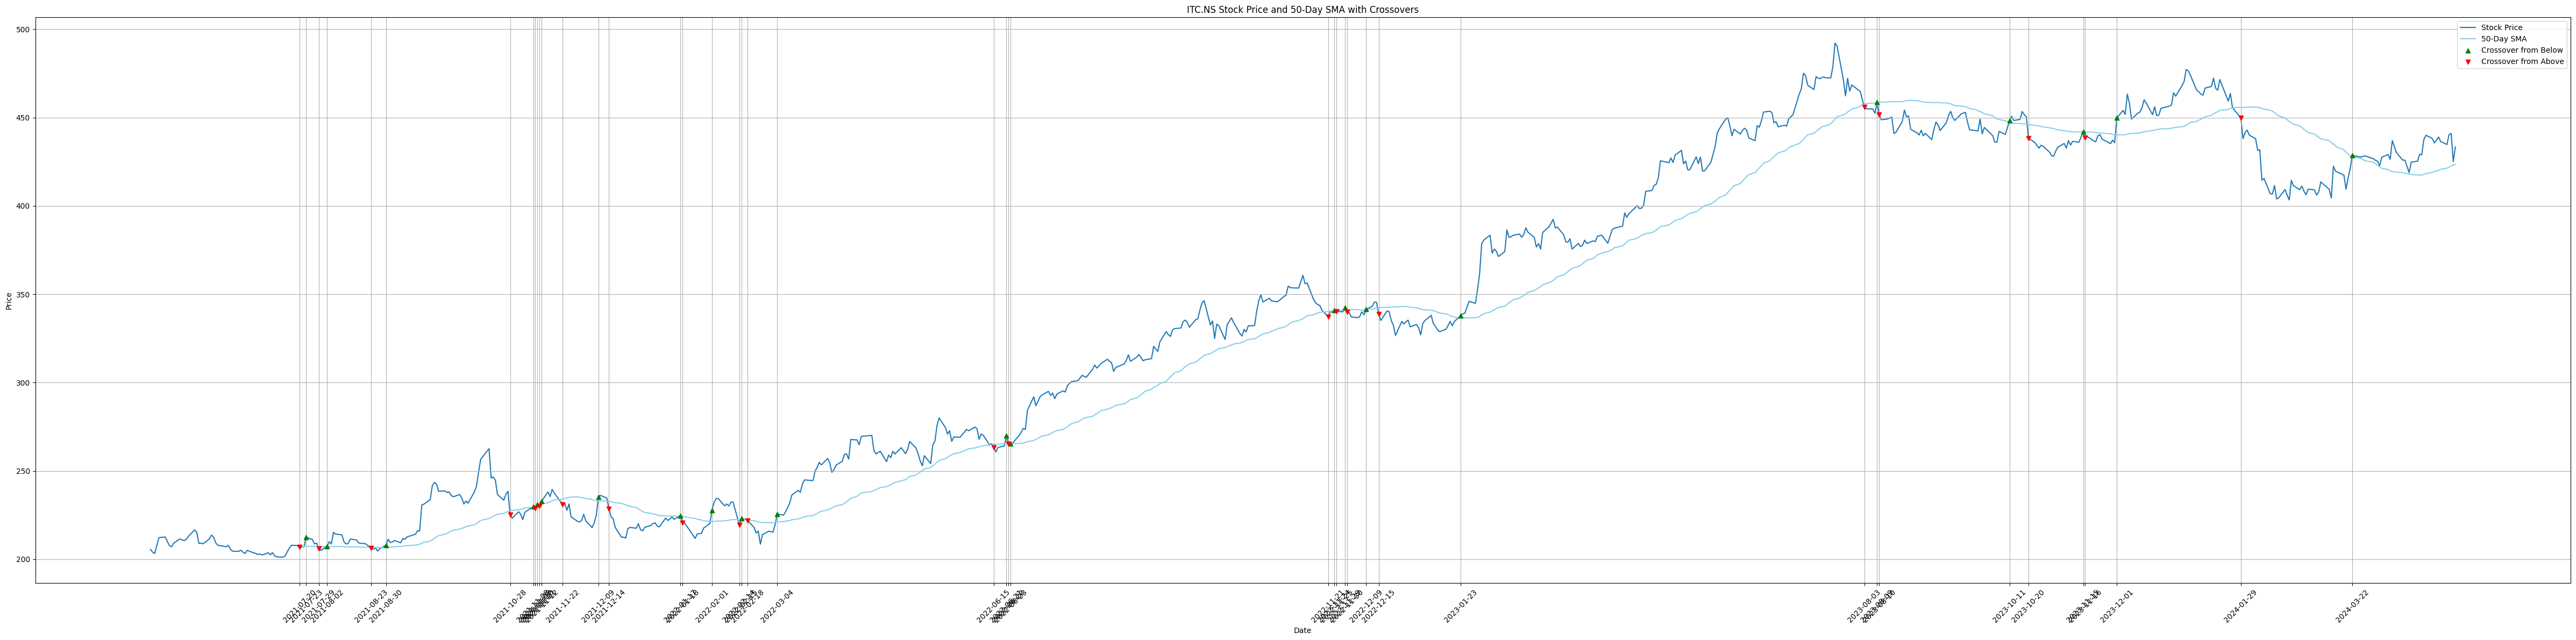

In [ ]:
import matplotlib.pyplot as plt

# Plot stock prices and SMA with crossover dates
plt.figure(figsize=(48,12))

# Plot stock price and SMA lines
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', zorder=1)
plt.plot(sma.index, sma, label=f'{window}-Day SMA', color='skyblue', zorder=2)

# Plot scatter markers for crossovers
plt.scatter(crossovers['from_below'], stock_data.loc[crossovers['from_below']]['Close'], color='green', marker='^', label='Crossover from Below', zorder=3)
plt.scatter(crossovers['from_above'], stock_data.loc[crossovers['from_above']]['Close'], color='red', marker='v', label='Crossover from Above', zorder=3)

# Customize plot appearance
plt.title(f'{symbol} Stock Price and {window}-Day SMA with Crossovers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(crossovers['from_below'] + crossovers['from_above'], rotation=45)  # Set x-axis ticks to crossover dates
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def note_crossovers(stock_data, sma):
    """
    Function to note the exact moving price when the stock price crossed the next day.

    Parameters:
        stock_data (pandas.DataFrame): DataFrame containing stock data.
        sma (pandas.Series): Series containing the SMA values.

    Returns:
        dict: Dictionary containing crossover dates, prices, and types (from above or from below).
    """
    crossovers = {'from_below': [], 'from_above': []}
    for i in range(1, len(stock_data)):
        if stock_data['Close'][i] > sma[i] and stock_data['Close'][i - 1] <= sma[i - 1]:
            crossovers['from_below'].append({'date': stock_data.index[i], 'price': stock_data['Close'][i], 'sma': sma[i]})
        elif stock_data['Close'][i] < sma[i] and stock_data['Close'][i - 1] >= sma[i - 1]:
            crossovers['from_above'].append({'date': stock_data.index[i], 'price': stock_data['Close'][i], 'sma': sma[i]})
    return crossovers

# Note crossovers
crossovers_info = note_crossovers(stock_data, sma)

# Print crossovers from below and above with exact price and SMA
print("Crossovers from below:")
for crossover in crossovers_info['from_below']:
    print(f"Date: {crossover['date']}, Price: {crossover['price']}, SMA: {crossover['sma']}")
print("\nCrossovers from above:")
for crossover in crossovers_info['from_above']:
    print(f"Date: {crossover['date']}, Price: {crossover['price']}, SMA: {crossover['sma']}")

print(crossovers_info)

Crossovers from below:
Date: 2021-07-23 00:00:00, Price: 212.39999389648438, SMA: 207.33600036621092
Date: 2021-08-02 00:00:00, Price: 207.3000030517578, SMA: 207.10600006103516
Date: 2021-08-30 00:00:00, Price: 208.0, SMA: 206.64999969482423
Date: 2021-11-08 00:00:00, Price: 229.8000030517578, SMA: 229.50599975585936
Date: 2021-11-10 00:00:00, Price: 230.85000610351562, SMA: 230.4879998779297
Date: 2021-11-12 00:00:00, Price: 232.89999389648438, SMA: 231.3599996948242
Date: 2021-12-09 00:00:00, Price: 235.39999389648438, SMA: 233.06499908447265
Date: 2022-01-17 00:00:00, Price: 224.60000610351562, SMA: 224.39699981689452
Date: 2022-02-01 00:00:00, Price: 227.75, SMA: 221.3850003051758
Date: 2022-02-15 00:00:00, Price: 223.0, SMA: 222.49500030517578
Date: 2022-03-04 00:00:00, Price: 225.5, SMA: 221.14500030517578
Date: 2022-06-21 00:00:00, Price: 269.8999938964844, SMA: 265.5639990234375
Date: 2022-06-23 00:00:00, Price: 265.5, SMA: 265.4739990234375
Date: 2022-11-24 00:00:00, Price: 3

In [ ]:
def combine_crossovers(crossovers_info):
    """
    Function to combine crossovers from below and crossovers from above.

    Parameters:
        crossovers_info (dict): Dictionary containing crossover dates, prices, and types (from above or from below).

    Returns:
        list: List of combined crossovers with type attribute, sorted by date.
    """
    combined_crossovers = []

    for crossover in crossovers_info['from_below']:
        crossover['type'] = 'from_below'
        combined_crossovers.append(crossover)

    for crossover in crossovers_info['from_above']:
        crossover['type'] = 'from_above'
        combined_crossovers.append(crossover)

    # Sort combined crossovers by date
    combined_crossovers.sort(key=lambda x: x['date'])

    return combined_crossovers

# Combine crossovers
combined_crossovers = combine_crossovers(crossovers_info)

# Print combined crossovers with type attribute, sorted by date
print("Combined crossovers:")
for crossover in combined_crossovers:
    print(f"Date: {crossover['date']}, Price: {crossover['price']}, SMA: {crossover['sma']}, Type: {crossover['type']}")


Combined crossovers:
Date: 2021-07-20 00:00:00, Price: 206.8000030517578, SMA: 207.09300048828126, Type: from_above
Date: 2021-07-23 00:00:00, Price: 212.39999389648438, SMA: 207.33600036621092, Type: from_below
Date: 2021-07-29 00:00:00, Price: 206.0500030517578, SMA: 207.18200012207032, Type: from_above
Date: 2021-08-02 00:00:00, Price: 207.3000030517578, SMA: 207.10600006103516, Type: from_below
Date: 2021-08-23 00:00:00, Price: 206.3000030517578, SMA: 206.75199981689454, Type: from_above
Date: 2021-08-30 00:00:00, Price: 208.0, SMA: 206.64999969482423, Type: from_below
Date: 2021-10-28 00:00:00, Price: 225.10000610351562, SMA: 227.32699920654298, Type: from_above
Date: 2021-11-08 00:00:00, Price: 229.8000030517578, SMA: 229.50599975585936, Type: from_below
Date: 2021-11-09 00:00:00, Price: 228.75, SMA: 229.98899963378906, Type: from_above
Date: 2021-11-10 00:00:00, Price: 230.85000610351562, SMA: 230.4879998779297, Type: from_below
Date: 2021-11-11 00:00:00, Price: 230.0, SMA: 230.

In [ ]:
def calculate_returns(combined_crossovers, stock_data):
    """
    Function to calculate returns/profits from crossovers.

    Parameters:
        combined_crossovers (list): List of combined crossovers with type attribute, sorted by date.
        stock_data (pandas.DataFrame): DataFrame containing stock data.

    Returns:
        float: Total profits from crossovers in percentage.
    """
    bought = False
    buy_price = 0
    total_return = 0

    for crossover in combined_crossovers:
        if crossover['type'] == 'from_below':
            if not bought:
                buy_price = crossover['sma']  # Buy at SMA price
                bought = True
                print(f"Bought at {buy_price} on {crossover['date']}")
            else:
                print(f"Already bought at {buy_price}, no crossover from below to buy again")
        elif crossover['type'] == 'from_above':
            if bought:
                sell_price = crossover['sma']  # Sell at SMA price
                percentage_return = ((sell_price - buy_price) / buy_price) * 100
                total_return += percentage_return
                print(f"Sold at {sell_price} on {crossover['date']}, Percentage Return: {percentage_return}%")
                bought = False
            else:
                print("No stock bought to sell")

    if bought:
        # If there are no more crossovers from above but the stock is still bought,
        # we sell the stock at the last available price
        last_price = stock_data.iloc[-1]['Close']
        percentage_return = ((last_price - buy_price) / buy_price) * 100
        total_return += percentage_return
        print(f"Sold at {last_price} on {stock_data.index[-1]}, Percentage Return: {percentage_return}%")

    return total_return

# Calculate returns
percentage_profit = calculate_returns(combined_crossovers, stock_data)
print("Total profits from crossovers:", percentage_profit, "%")


No stock bought to sell
Bought at 207.33600036621092 on 2021-07-23 00:00:00
Sold at 207.18200012207032 on 2021-07-29 00:00:00, Percentage Return: -0.07427568963836423%
Bought at 207.10600006103516 on 2021-08-02 00:00:00
Sold at 206.75199981689454 on 2021-08-23 00:00:00, Percentage Return: -0.1709270827674215%
Bought at 206.64999969482423 on 2021-08-30 00:00:00
Sold at 227.32699920654298 on 2021-10-28 00:00:00, Percentage Return: 10.005806698405054%
Bought at 229.50599975585936 on 2021-11-08 00:00:00
Sold at 229.98899963378906 on 2021-11-09 00:00:00, Percentage Return: 0.21045196136201177%
Bought at 230.4879998779297 on 2021-11-10 00:00:00
Sold at 230.9279998779297 on 2021-11-11 00:00:00, Percentage Return: 0.1908993093926925%
Bought at 231.3599996948242 on 2021-11-12 00:00:00
Sold at 233.9709994506836 on 2021-11-22 00:00:00, Percentage Return: 1.1285441559921445%
Bought at 233.06499908447265 on 2021-12-09 00:00:00
Sold at 232.8109994506836 on 2021-12-14 00:00:00, Percentage Return: -0.

In [ ]:
# Stocks to watch
# If their current closing price is +- 10% of the current moving average

import pandas as pd
ticks = pd.read_csv("/content/valid_ticks.csv")


In [ ]:
watch_ticks = []
count = 1
watch_count = 1

for tick in ticks['ticks']:
     # Example usage:
    symbol = tick + ".NS"
    period = "3y"
    window = 200
    stock_data = get_stock_data(symbol, period)
    sma = calculate_sma(stock_data, window)
    if (stock_data['Close'][-1] >= sma[-1]*0.96 and stock_data['Close'][-1] <= sma[-1]*1.04):
        watch_ticks.append(tick)
        print("Tick:", tick, ":: Watch count:", watch_count)
        watch_count += 1
    print(count)
    count += 1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1
2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


3
4


[*********************100%%**********************]  1 of 1 completed


5


[*********************100%%**********************]  1 of 1 completed


6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


7
8


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ITC :: Watch count: 1
9
10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LT :: Watch count: 2
11
12


[*********************100%%**********************]  1 of 1 completed


13


[*********************100%%**********************]  1 of 1 completed


14


[*********************100%%**********************]  1 of 1 completed


15


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ADANIENT :: Watch count: 3
16
17


[*********************100%%**********************]  1 of 1 completed


Tick: TITAN :: Watch count: 4
18


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


19
20


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


21
22


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


23
24


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


25
Tick: ULTRACEMCO :: Watch count: 5
26


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


27
28


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BAJAJFINSV :: Watch count: 6
29
30


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


31
32


[*********************100%%**********************]  1 of 1 completed


Tick: WIPRO :: Watch count: 7
33


[*********************100%%**********************]  1 of 1 completed


34


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


35
36


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


37
38


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


39
40


[*********************100%%**********************]  1 of 1 completed


41


[*********************100%%**********************]  1 of 1 completed


42


[*********************100%%**********************]  1 of 1 completed


43


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


44
45


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


46
47


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SBILIFE :: Watch count: 8
48
49


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


50
51


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


52
53


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


54
55


[*********************100%%**********************]  1 of 1 completed


56


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

57



[*********************100%%**********************]  1 of 1 completed


58
59


[*********************100%%**********************]  1 of 1 completed


60


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


61
62


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TECHM :: Watch count: 9
63
64


[*********************100%%**********************]  1 of 1 completed


65


[*********************100%%**********************]  1 of 1 completed


Tick: CIPLA :: Watch count: 10
66


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


67
68


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


69
70


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


71
72


[*********************100%%**********************]  1 of 1 completed


73


[*********************100%%**********************]  1 of 1 completed


74


[*********************100%%**********************]  1 of 1 completed


75


[*********************100%%**********************]  1 of 1 completed


76


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DRREDDY :: Watch count: 11
77
78


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


79
80


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


81
82


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


83
84


[*********************100%%**********************]  1 of 1 completed


Tick: DABUR :: Watch count: 12
85


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SHREECEM :: Watch count: 13
86
87


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


88
Tick: DIVISLAB :: Watch count: 14
89


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


90
91


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


92
93


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


94
95


[*********************100%%**********************]  1 of 1 completed


96


[*********************100%%**********************]  1 of 1 completed


97


[*********************100%%**********************]  1 of 1 completed


98


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


99
100


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


101
102


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


103
104


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


105
106


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


107
108


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


109
110


[*********************100%%**********************]  1 of 1 completed


111


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SRF :: Watch count: 15
112
113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

114



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


115
116
117


[*********************100%%**********************]  1 of 1 completed


118


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


119
120


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


121
122


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


123
124


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


125
126


[*********************100%%**********************]  1 of 1 completed


127


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


128
129


[*********************100%%**********************]  1 of 1 completed


Tick: PERSISTENT :: Watch count: 16
130


[*********************100%%**********************]  1 of 1 completed


131


[*********************100%%**********************]  1 of 1 completed


132


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


133
Tick: PIIND :: Watch count: 17
134


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


135
136


[*********************100%%**********************]  1 of 1 completed


Tick: TATACOMM :: Watch count: 18
137


[*********************100%%**********************]  1 of 1 completed


138


[*********************100%%**********************]  1 of 1 completed


139


[*********************100%%**********************]  1 of 1 completed


140


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


141
142


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


143
144


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


145
146


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


147
148


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


149
150


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


151
152


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


153
154


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


155
156


[*********************100%%**********************]  1 of 1 completed


157


[*********************100%%**********************]  1 of 1 completed


158


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


159
160


[*********************100%%**********************]  1 of 1 completed


161


[*********************100%%**********************]  1 of 1 completed


162


[*********************100%%**********************]  1 of 1 completed


163


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


164
165


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


166
167


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BALKRISIND :: Watch count: 19
168
169


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


170
171


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


172
173


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: APLAPOLLO :: Watch count: 20
174
175


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SONACOMS :: Watch count: 21
176
177


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: FACT :: Watch count: 22
178
179


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


180
181


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


182
183


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


184
185


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


186
187


[*********************100%%**********************]  1 of 1 completed


188


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CRISIL :: Watch count: 23
189
Tick: AIAENG :: Watch count: 24
190


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


191
192


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


193
194


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


195
196


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


197
198


[*********************100%%**********************]  1 of 1 completed


199


[*********************100%%**********************]  1 of 1 completed


200


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


201
202


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


203
Tick: FLUOROCHEM :: Watch count: 25
204


[*********************100%%**********************]  1 of 1 completed


205


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


206
207


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


208
209


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


210
211


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


212
213


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


214
215


[*********************100%%**********************]  1 of 1 completed


Tick: JKCEMENT :: Watch count: 26
216


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


217
218


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

219



[*********************100%%**********************]  1 of 1 completed


220
221


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GLAND :: Watch count: 27
222
Tick: IGL :: Watch count: 28
223


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


224
225


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


226
227


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


228
229


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


230
231


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


232
Tick: KPRMILL :: Watch count: 29
233


[*********************100%%**********************]  1 of 1 completed


234


[*********************100%%**********************]  1 of 1 completed


235


[*********************100%%**********************]  1 of 1 completed


236


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


237
Tick: TATACHEM :: Watch count: 30
238


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


239
240


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


241
242


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


243
244


[*********************100%%**********************]  1 of 1 completed


245


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


246
247


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


248
249


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


250
251


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


252


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


253
254
255


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ISEC :: Watch count: 31
256
257


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


258
259


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


260
261


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


262
263


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


264
265


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


266
267


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


268
269


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


270
271


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GRINDWELL :: Watch count: 32
272
Tick: FIVESTAR :: Watch count: 33
273


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


274
Tick: CHOLAHLDNG :: Watch count: 34
275


[*********************100%%**********************]  1 of 1 completed


276


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


277
278


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


279
Tick: RELAXO :: Watch count: 35
280


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


281
282


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


283
284


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


285
286


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


287
288


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


289
290


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LALPATHLAB :: Watch count: 36
291
292


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SANOFI :: Watch count: 37
293
294


[*********************100%%**********************]  1 of 1 completed


Tick: TRIDENT :: Watch count: 38
295


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


296
297


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KAYNES :: Watch count: 39
298
299


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


300
301


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


302
303


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


304
305


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


306
Tick: CIEINDIA :: Watch count: 40
307


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


308
309


[*********************100%%**********************]  1 of 1 completed


Tick: SUMICHEM :: Watch count: 41
310


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


311
312


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


313
314


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


315
316


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


317
318


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


319
320


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


321
322


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KIMS :: Watch count: 42
323
324


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PNBHOUSING :: Watch count: 43
325
326


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


327
328


[*********************100%%**********************]  1 of 1 completed


329


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


330
331


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


332
333


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: INDIAMART :: Watch count: 44
334
335


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


336
Tick: WHIRLPOOL :: Watch count: 45
337


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


338
339


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


340
Tick: APTUS :: Watch count: 46
341


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: FINCABLES :: Watch count: 47
342
343


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


344
345


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


346
347


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


348
349


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


350
351


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AFFLE :: Watch count: 48
352
353


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RBLBANK :: Watch count: 49
354
355


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


356
357


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


358
359


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CENTURYPLY :: Watch count: 50
360
361


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


362
363


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


364
365


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


366
367


[*********************100%%**********************]  1 of 1 completed


368


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


369
370


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


371
Tick: WELSPUNLIV :: Watch count: 51
372


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


373
Tick: DCMSHRIRAM :: Watch count: 52
374


[*********************100%%**********************]  1 of 1 completed


375


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


376
377


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


378
379


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


380
381


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


382
383


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


384
385


[*********************100%%**********************]  1 of 1 completed


386


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


387
388


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


389
390


[*********************100%%**********************]  1 of 1 completed


Tick: WESTLIFE :: Watch count: 53
391


[*********************100%%**********************]  1 of 1 completed


Tick: RKFORGE :: Watch count: 54
392


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


393
394


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: FINEORG :: Watch count: 55
395
396


[*********************100%%**********************]  1 of 1 completed


Tick: BIKAJI :: Watch count: 56
397


[*********************100%%**********************]  1 of 1 completed


398


[*********************100%%**********************]  1 of 1 completed


399


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: IEX :: Watch count: 57
400
401


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


402
403


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


404
405


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ECLERX :: Watch count: 58
406
407


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ERIS :: Watch count: 59
408
409


[*********************100%%**********************]  1 of 1 completed


410


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MAHSEAMLES :: Watch count: 60
411
412


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


413
414


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


415
416


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


417
418


[*********************100%%**********************]  1 of 1 completed


419


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


420
421


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


422
Tick: AKZOINDIA :: Watch count: 61
423


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


424
425


[*********************100%%**********************]  1 of 1 completed


426


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


427
428


[*********************100%%**********************]  1 of 1 completed


429


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


430
431


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: EQUITASBNK :: Watch count: 62
432
433


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


434
435


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


436
437


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


438
439


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


440
Tick: JKLAKSHMI :: Watch count: 63
441


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


442
443


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


444
445


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


446
447


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


448
Tick: SAPPHIRE :: Watch count: 64
449


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


450
451


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


452
453


[*********************100%%**********************]  1 of 1 completed


454


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PRAJIND :: Watch count: 65
455
456


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


457
458


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


459
460


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


461
462


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


463
464


[*********************100%%**********************]  1 of 1 completed


465


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


466
467


[*********************100%%**********************]  1 of 1 completed


468


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


469
470


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GNFC :: Watch count: 66
471
472


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


473
474


[*********************100%%**********************]  1 of 1 completed


475


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


476
477


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


478
Tick: PRSMJOHNSN :: Watch count: 67
479


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


480
481


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


482
483


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


484
Tick: UJJIVANSFB :: Watch count: 68
485


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


486
487


[*********************100%%**********************]  1 of 1 completed


Tick: RATEGAIN :: Watch count: 69
488


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


489
Tick: SAFARI :: Watch count: 70
490


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


491
492


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SHOPERSTOP :: Watch count: 71
493
494


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


495
496


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ACI :: Watch count: 72
497
498


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MAHSCOOTER :: Watch count: 73
499
500


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


501
502


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


503
504


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


505
506


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


507
Tick: MHRIL :: Watch count: 74
508


[*********************100%%**********************]  1 of 1 completed


509


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


510
511


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


512
513


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


514
515


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


516
517


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


518
Tick: VARROC :: Watch count: 75
519


[*********************100%%**********************]  1 of 1 completed


520


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


521
Tick: EASEMYTRIP :: Watch count: 76
522


[*********************100%%**********************]  1 of 1 completed


523


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: IONEXCHANG :: Watch count: 77
524
Tick: RESPONIND :: Watch count: 78
525


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MIDHANI :: Watch count: 79
526
527


[*********************100%%**********************]  1 of 1 completed


528


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


529
530


[*********************100%%**********************]  1 of 1 completed


531


[*********************100%%**********************]  1 of 1 completed


532


[*********************100%%**********************]  1 of 1 completed


533


[*********************100%%**********************]  1 of 1 completed


Tick: SOUTHBANK :: Watch count: 80
534


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


535
Tick: CHEMPLASTS :: Watch count: 81
536


[*********************100%%**********************]  1 of 1 completed


537


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RCF :: Watch count: 82
538
539


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


540
541


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


542
543


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


544
545


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GRAVITA :: Watch count: 83
546
547


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


548
549


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


550
551


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TRIVENI :: Watch count: 84
552
553


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GARFIBRES :: Watch count: 85
554
555


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


556
557


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


558
559


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BALAMINES :: Watch count: 86
560
561


[*********************100%%**********************]  1 of 1 completed


562


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


563
564


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


565
566


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


567
568


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BORORENEW :: Watch count: 87
569
570


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


571
572


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CMSINFO :: Watch count: 88
573
574


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


575
576


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


577
578


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JINDWORLD :: Watch count: 89
579
580


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


581
582


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CSBBANK :: Watch count: 90
583
584


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


585
Tick: PRINCEPIPE :: Watch count: 91
586


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


587
588


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


589
590


[*********************100%%**********************]  1 of 1 completed


591


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


592
593


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


594
595


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


596
597


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


598
599


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


600
601


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


602
Tick: CYIENTDLM :: Watch count: 92
603


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: EPL :: Watch count: 93
604



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SUPRAJIT :: Watch count: 94
605
606
607


[*********************100%%**********************]  1 of 1 completed


608


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


609
610


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


611
612


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


613
614


[*********************100%%**********************]  1 of 1 completed


615


[*********************100%%**********************]  1 of 1 completed


Tick: SURYAROSNI :: Watch count: 95
616


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


617
618


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


619
620


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


621
622


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


623
624


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


625
626


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


627
628


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


629
630


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


631
632


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


633
634


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


635
636


[*********************100%%**********************]  1 of 1 completed


637


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JAICORPLTD :: Watch count: 96
638
639


[*********************100%%**********************]  1 of 1 completed


Tick: GATEWAY :: Watch count: 97
640


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


641
642


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


643
644


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


645
646


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


647
648


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


649
650


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


651
Tick: HCG :: Watch count: 98
652


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


653
Tick: DBCORP :: Watch count: 99
654


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


655
656


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MASFIN :: Watch count: 100
657
658


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


659
660


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


661
662


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


663
664


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


665
666


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TIIL :: Watch count: 101
667
668


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


669
Tick: HEIDELBERG :: Watch count: 102
670


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


671
672


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PATELENG :: Watch count: 103
673
674


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


675
676


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


677
678


[*********************100%%**********************]  1 of 1 completed


679


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


680
681


[*********************100%%**********************]  1 of 1 completed


Tick: VMART :: Watch count: 104
682


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

683



[*********************100%%**********************]  1 of 1 completed


684
685


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


686
687


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NOCIL :: Watch count: 105
688
689


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


690
691


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


692
693


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


694
Tick: FCL :: Watch count: 106
695


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


696
697


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


698
699


[*********************100%%**********************]  1 of 1 completed


Tick: TI :: Watch count: 107
700


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AMIORG :: Watch count: 108
701
Tick: ORIENTCEM :: Watch count: 109
702


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


703
704


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


705
706


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


707
Tick: WSTCSTPAPR :: Watch count: 110
708


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


709
Tick: PRIVISCL :: Watch count: 111
710


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


711
712


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


713
714


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


715
716


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


717
Tick: DCBBANK :: Watch count: 112
718


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


719
720


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


721
Tick: HARSHA :: Watch count: 113
722


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


723
724


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


725
726


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


727
Tick: BHARATRAS :: Watch count: 114
728


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KOLTEPATIL :: Watch count: 115
729
730


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


731
732


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HATHWAY :: Watch count: 116
733
734


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


735
736


[*********************100%%**********************]  1 of 1 completed


737


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


738
739


[*********************100%%**********************]  1 of 1 completed


740


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


741
742


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SUNFLAG :: Watch count: 117
743
744


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


745
746


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


747
748


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


749
750


[*********************100%%**********************]  1 of 1 completed


Tick: HIKAL :: Watch count: 118
751


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


752
753


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AVALON :: Watch count: 119
754
755


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NUCLEUS :: Watch count: 120
756
757


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

758



[*********************100%%**********************]  1 of 1 completed


759
760


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


761
762


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JTLIND :: Watch count: 121
763
764


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


765
766


[*********************100%%**********************]  1 of 1 completed


767


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NAVNETEDUL :: Watch count: 122
768
Tick: KDDL :: Watch count: 123
769


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


770
Tick: LANDMARK :: Watch count: 124
771


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


772
773


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TVSSRICHAK :: Watch count: 125
774
775


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SBCL :: Watch count: 126
776
777


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PRAKASH :: Watch count: 127
778
779


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


780
781


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


782
783


[*********************100%%**********************]  1 of 1 completed


784


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


785
Tick: UFLEX :: Watch count: 128
786


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


787
788


[*********************100%%**********************]  1 of 1 completed


Tick: BANARISUG :: Watch count: 129
789


[*********************100%%**********************]  1 of 1 completed


790


[*********************100%%**********************]  1 of 1 completed


791


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


792
793


[*********************100%%**********************]  1 of 1 completed


794


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


795
796


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


797
798


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


799
800


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


801
802


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


803
804


[*********************100%%**********************]  1 of 1 completed


805


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


806
807


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


808
809


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


810
811


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


812
813


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


814
Tick: VINDHYATEL :: Watch count: 130
815


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


816
817


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: MPSLTD :: Watch count: 131
818



[*********************100%%**********************]  1 of 1 completed


Tick: MARATHON :: Watch count: 132
819
820


[*********************100%%**********************]  1 of 1 completed


821


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


822
Tick: JCHAC :: Watch count: 133
823


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


824
825


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


826
Tick: SHALBY :: Watch count: 134
827


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


828
829


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


830
831


[*********************100%%**********************]  1 of 1 completed


832


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


833
834


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


835
836


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


837
838


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


839
840


[*********************100%%**********************]  1 of 1 completed


841


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PARAGMILK :: Watch count: 135
842
843


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


844
845


[*********************100%%**********************]  1 of 1 completed


Tick: XPROINDIA :: Watch count: 136
846


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


847
848


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


849
850


[*********************100%%**********************]  1 of 1 completed


851


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CONFIPET :: Watch count: 137
852
853


[*********************100%%**********************]  1 of 1 completed


854


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


855
Tick: PARAS :: Watch count: 138
856


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

857



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


858
859
860


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


861
862


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


863
864


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


865
866


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: INDIAGLYCO :: Watch count: 139
867
868


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


869
870


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


871
Tick: SATIN :: Watch count: 140
872


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: AXISCADES :: Watch count: 141
873



[*********************100%%**********************]  1 of 1 completed


874
875


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


876
877


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


878
879


[*********************100%%**********************]  1 of 1 completed


880


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HUHTAMAKI :: Watch count: 142
881
882


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

883



[*********************100%%**********************]  1 of 1 completed


884
885


[*********************100%%**********************]  1 of 1 completed


886


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HONDAPOWER :: Watch count: 143
887
888


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


889
890


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: SANGAMIND :: Watch count: 144
891



[*********************100%%**********************]  1 of 1 completed


Tick: BEPL :: Watch count: 145
892
893


[*********************100%%**********************]  1 of 1 completed


894


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


895
896


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


897
898


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


899
900


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


901
902


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MUKANDLTD :: Watch count: 146
903
904


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ALEMBICLTD :: Watch count: 147
905
906


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


907
908


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


909
910


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ASTEC :: Watch count: 148
911
912


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


913
914


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


915
Tick: RPSGVENT :: Watch count: 149
916


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

917



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


918
919
920


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SDBL :: Watch count: 150
921
922


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TCPLPACK :: Watch count: 151
923
924


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


925
Tick: MOL :: Watch count: 152
926


[*********************100%%**********************]  1 of 1 completed


927


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


928
Tick: PANAMAPET :: Watch count: 153
929


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


930
931


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


932
Tick: MAYURUNIQ :: Watch count: 154
933


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


934
935


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

936



[*********************100%%**********************]  1 of 1 completed

937



[*********************100%%**********************]  1 of 1 completed


938
939


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


940
941


[*********************100%%**********************]  1 of 1 completed


942


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


943
944


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ANDHRAPAP :: Watch count: 155
945
946


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RIIL :: Watch count: 156
947
948


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


949
950


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


951
Tick: SJS :: Watch count: 157
952


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PARACABLES :: Watch count: 158
953
954


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


955
956


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GTPL :: Watch count: 159
957
958


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ADORWELD :: Watch count: 160
959
960


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


961
962


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SESHAPAPER :: Watch count: 161
963
964


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


965
966


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GOLDIAM :: Watch count: 162
967
Tick: PIXTRANS :: Watch count: 163
968


[*********************100%%**********************]  1 of 1 completed


969


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


970
971


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


972
Tick: FMGOETZE :: Watch count: 164
973


[*********************100%%**********************]  1 of 1 completed


974


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


975
976


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


977
978


[*********************100%%**********************]  1 of 1 completed


979


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


980
981


[*********************100%%**********************]  1 of 1 completed


982


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


983
984


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


985
986


[*********************100%%**********************]  1 of 1 completed


Tick: TNPL :: Watch count: 165
987


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


988
989


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


990
991


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


992
993


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: EVERESTIND :: Watch count: 166
994
995


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


996
997


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


998
999


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1000
1001


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1002
Tick: 5PAISA :: Watch count: 167
1003


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KIRIINDUS :: Watch count: 168
1004
1005


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1006
1007


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1008
1009


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1010
Tick: BLKASHYAP :: Watch count: 169
1011


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1012
1013


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1014
1015


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1016
1017


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1018
Tick: BCLIND :: Watch count: 170
1019


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1020
1021


[*********************100%%**********************]  1 of 1 completed


1022


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1023
1024


[*********************100%%**********************]  1 of 1 completed


Tick: EKC :: Watch count: 171
1025


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1026
1027


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1028
1029


[*********************100%%**********************]  1 of 1 completed


1030


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SPAL :: Watch count: 172
1031
1032


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1033
1034


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1035
Tick: INSECTICID :: Watch count: 173
1036


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1037
1038


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SPIC :: Watch count: 174
1039
1040


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1041
Tick: SPCENET :: Watch count: 175
1042


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1043
1044


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1045
1046


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1047
1048


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1049
1050


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1051
Tick: VASCONEQ :: Watch count: 176
1052


[*********************100%%**********************]  1 of 1 completed


1053


[*********************100%%**********************]  1 of 1 completed


1054


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: INDIANHUME :: Watch count: 177
1055
Tick: ROSSELLIND :: Watch count: 178
1056


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1057
1058


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1059
Tick: ALICON :: Watch count: 179
1060


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1061
Tick: IGPL :: Watch count: 180
1062


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1063
1064


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1065
Tick: ATULAUTO :: Watch count: 181
1066


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1067
1068


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1069
1070


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1071
1072


[*********************100%%**********************]  1 of 1 completed


1073


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1074
1075


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1076
1077


[*********************100%%**********************]  1 of 1 completed


1078


[*********************100%%**********************]  1 of 1 completed


1079


[*********************100%%**********************]  1 of 1 completed


1080


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AVTNPL :: Watch count: 182
1081
1082


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TVTODAY :: Watch count: 183
1083
1084


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1085
1086


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KOPRAN :: Watch count: 184
1087
1088


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1089
1090


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1091
1092


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1093
1094


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1095
1096


[*********************100%%**********************]  1 of 1 completed


1097


[*********************100%%**********************]  1 of 1 completed


1098


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1099
1100


[*********************100%%**********************]  1 of 1 completed


1101


[*********************100%%**********************]  1 of 1 completed


1102


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: REPRO :: Watch count: 185
1103
1104


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1105
1106


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1107
1108


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BLISSGVS :: Watch count: 186
1109
1110


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LINCOLN :: Watch count: 187
1111
1112


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1113
1114


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1115
1116


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1117
1118


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1119
1120


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1121
1122


[*********************100%%**********************]  1 of 1 completed


1123


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1124
Tick: NELCAST :: Watch count: 188
1125


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1126
1127


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1128
Tick: ROTO :: Watch count: 189
1129


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: STERTOOLS :: Watch count: 190
1130
1131


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1132
1133


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GICHSGFIN :: Watch count: 191
1134
1135


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1136
1137


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1138
1139


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1140
1141


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1142
Tick: SPORTKING :: Watch count: 192
1143


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CLSEL :: Watch count: 193
1144
1145


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1146
1147


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1148
1149


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1150
1151


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1152
1153


[*********************100%%**********************]  1 of 1 completed


1154


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1155
1156


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1157
Tick: OAL :: Watch count: 194
1158


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1159
1160


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1161
1162


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1163
1164


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1165
Tick: VIMTALABS :: Watch count: 195
1166


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1167
Tick: GSLSU :: Watch count: 196
1168


[*********************100%%**********************]  1 of 1 completed


1169


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1170
1171


[*********************100%%**********************]  1 of 1 completed


1172


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1173
1174


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1175
Tick: KELLTONTEC :: Watch count: 197
1176


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1177
1178


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1179
1180


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1181
Tick: UNIENTER :: Watch count: 198
1182


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1183
1184


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: VISAKAIND :: Watch count: 199
1185
1186


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1187
1188


[*********************100%%**********************]  1 of 1 completed


1189


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1190
Tick: NINSYS :: Watch count: 200
1191


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1192
Tick: VHL :: Watch count: 201
1193


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: TRACXN :: Watch count: 202
1194



[*********************100%%**********************]  1 of 1 completed


1195
1196


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1197
1198


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1199
Tick: HPAL :: Watch count: 203
1200


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1201
1202


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1203
1204


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1205
1206


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1207
1208


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1209
1210


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1211
1212


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PPL :: Watch count: 204
1213
Tick: NCLIND :: Watch count: 205
1214


[*********************100%%**********************]  1 of 1 completed


Tick: HEXATRADEX :: Watch count: 206
1215


[*********************100%%**********************]  1 of 1 completed


1216


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1217
1218


[*********************100%%**********************]  1 of 1 completed


1219


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1220
1221


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DYCL :: Watch count: 207
1222
1223


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1224
1225


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1226
1227


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1228
1229


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1230
Tick: INDOAMIN :: Watch count: 208
1231


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1232
Tick: ADSL :: Watch count: 209
1233


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1234
1235


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1236
1237


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DHARMAJ :: Watch count: 210
1238
1239


[*********************100%%**********************]  1 of 1 completed


Tick: CHEVIOT :: Watch count: 211
1240


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1241
1242


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1243
1244


[*********************100%%**********************]  1 of 1 completed


1245


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: STCINDIA :: Watch count: 212
1246
Tick: TRU :: Watch count: 213
1247


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1248
1249


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1250
1251


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1252
1253


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1254
1255


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KOTHARIPET :: Watch count: 214
1256
Tick: CONSOFINVT :: Watch count: 215
1257


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1258
1259


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1260
1261


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SUKHJITS :: Watch count: 216
1262
1263


[*********************100%%**********************]  1 of 1 completed


1264


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1265
1266


[*********************100%%**********************]  1 of 1 completed


1267


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1268
1269


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1270
1271


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1272
1273


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1274
1275


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DMCC :: Watch count: 217
1276
1277


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1278
1279


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1280
1281


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1282
1283


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KRITI :: Watch count: 218
1284
Tick: ELIN :: Watch count: 219
1285


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1286
1287


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1288
Tick: MUNJALSHOW :: Watch count: 220
1289


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1290
1291


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JAYAGROGN :: Watch count: 221
1292
1293


[*********************100%%**********************]  1 of 1 completed


1294


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SREEL :: Watch count: 222
1295
1296


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1297
1298


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BHAGERIA :: Watch count: 223
1299
1300


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1301
1302


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1303
Tick: KHAICHEM :: Watch count: 224
1304


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1305
1306


[*********************100%%**********************]  1 of 1 completed


1307


[*********************100%%**********************]  1 of 1 completed


Tick: KAMATHOTEL :: Watch count: 225
1308


[*********************100%%**********************]  1 of 1 completed


Tick: HTMEDIA :: Watch count: 226
1309


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1310
1311


[*********************100%%**********************]  1 of 1 completed


1312


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1313
1314


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PLASTIBLEN :: Watch count: 227
1315
1316


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1317
1318


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1319
1320


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1321
1322


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1323
1324


[*********************100%%**********************]  1 of 1 completed


1325


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HINDCOMPOS :: Watch count: 228
1326
1327


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1328
1329


[*********************100%%**********************]  1 of 1 completed


1330


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1331
1332


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1333
1334


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1335
1336


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1337
1338


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1339
1340


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AXITA :: Watch count: 229
1341
1342


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1343
1344


[*********************100%%**********************]  1 of 1 completed


Tick: BBTCL :: Watch count: 230
1345


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1346
Tick: RACE :: Watch count: 231
1347


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RITCO :: Watch count: 232
1348
1349


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1350
1351


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1352
1353


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PTL :: Watch count: 233
1354
1355


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1356
1357


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1358
1359


[*********************100%%**********************]  1 of 1 completed


1360


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DONEAR :: Watch count: 234
1361
1362


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: INTLCONV :: Watch count: 235
1363
1364


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PRITIKAUTO :: Watch count: 236
1365
1366


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1367
Tick: BANSWRAS :: Watch count: 237
1368


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1369
1370


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1371
1372


[*********************100%%**********************]  1 of 1 completed


1373


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1374
1375


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1376
1377


[*********************100%%**********************]  1 of 1 completed


1378


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1379
1380


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1381
Tick: GLOBAL :: Watch count: 238
1382


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BRNL :: Watch count: 239
1383
1384


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1385
1386


[*********************100%%**********************]  1 of 1 completed


1387


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1388
1389


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ZIMLAB :: Watch count: 240
1390
1391


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: UNIDT :: Watch count: 241
1392



[*********************100%%**********************]  1 of 1 completed


1393
1394


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1395
Tick: AUTOIND :: Watch count: 242
1396


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1397
Tick: NBIFIN :: Watch count: 243
1398


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1399
1400


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1401
1402



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GOLDTECH :: Watch count: 244
1403
1404


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: WINDMACHIN :: Watch count: 245
1405
Tick: APOLSINHOT :: Watch count: 246
1406


[*********************100%%**********************]  1 of 1 completed


1407


[*********************100%%**********************]  1 of 1 completed


1408


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1409
1410


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1411
1412


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1413
1414


[*********************100%%**********************]  1 of 1 completed


Tick: CINELINE :: Watch count: 247
1415


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1416
1417


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1418
1419


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KAYA :: Watch count: 248
1420
1421


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1422
1423


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1424
Tick: SHEMAROO :: Watch count: 249
1425


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1426
Tick: DICIND :: Watch count: 250
1427


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1428
1429


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1430
1431


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1432
1433


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1434
Tick: KCPSUGIND :: Watch count: 251
1435


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1436
1437


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1438
1439


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1440
Tick: SINTERCOM :: Watch count: 252
1441


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PODDARMENT :: Watch count: 253
1442
1443


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1444
1445


[*********************100%%**********************]  1 of 1 completed


1446


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: STARPAPER :: Watch count: 254
1447
1448


[*********************100%%**********************]  1 of 1 completed


1449


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PONNIERODE :: Watch count: 255
1450
1451


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KOTHARIPRO :: Watch count: 256
1452
Tick: GOKUL :: Watch count: 257
1453


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1454
1455


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1456
1457


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1458
1459


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1460
1461


[*********************100%%**********************]  1 of 1 completed


1462


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1463
1464


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1465
1466


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1467
1468


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1469
Tick: SHREERAMA :: Watch count: 258
1470


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1471
1472


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1473
1474


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1475
Tick: EQUIPPP :: Watch count: 259
1476


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1477
1478


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1479
1480


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1481
1482


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1483
1484


[*********************100%%**********************]  1 of 1 completed


Tick: SHREYANIND :: Watch count: 260
1485


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1486
1487


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1488
1489


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1490
Tick: AIRAN :: Watch count: 261
1491


[*********************100%%**********************]  1 of 1 completed


Tick: VIRINCHI :: Watch count: 262
1492


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1493


1494


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1495
1496


[*********************100%%**********************]  1 of 1 completed


1497


[*********************100%%**********************]  1 of 1 completed


1498


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1499
1500


[*********************100%%**********************]  1 of 1 completed


Tick: TEMBO :: Watch count: 263
1501


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1502
Tick: AARON :: Watch count: 264
1503


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JAYSREETEA :: Watch count: 265
1504
1505


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MURUDCERA :: Watch count: 266
1506
1507


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1508
1509


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1510
1511


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1512
1513


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1514
1515


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1516
1517


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1518
1519


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1520
1521


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1522
1523


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1524
1525


[*********************100%%**********************]  1 of 1 completed


1526


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1527
Tick: MCLEODRUSS :: Watch count: 267
1528


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1529
1530


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1531
1532


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BASML :: Watch count: 268
1533
1534


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1535
1536


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1537
1538


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1539
Tick: AHLEAST :: Watch count: 269
1540


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: VETO :: Watch count: 270
1541
1542


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1543
1544


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1545
1546


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TEXMOPIPES :: Watch count: 271
1547
1548


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1549
1550


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1551
1552


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1553
1554


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1555
1556


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1557
1558


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1559
1560


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NECCLTD :: Watch count: 272
1561
1562


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1563
1564


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1565
1566


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1567
1568


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1569
1570


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1571
1572


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1573
Tick: AKSHARCHEM :: Watch count: 273
1574


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1575
1576


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1577
1578


[*********************100%%**********************]  1 of 1 completed


1579


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RAJSREESUG :: Watch count: 274
1580
1581


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1582
1583


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1584
1585


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1586
1587


[*********************100%%**********************]  1 of 1 completed


1588


[*********************100%%**********************]  1 of 1 completed


1589


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1590
1591


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1592
1593


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AARVI :: Watch count: 275
1594
1595


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ALPA :: Watch count: 276
1596
1597


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1598
1599


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: EROSMEDIA :: Watch count: 277
1600
1601


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1602
1603


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1604
1605


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1606
Tick: BSL :: Watch count: 278
1607



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1608
1609


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1610
1611


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SALONA :: Watch count: 279
1612
1613


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1614
1615


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: WORTH :: Watch count: 280
1616
1617


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1618
1619


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1620
Tick: UNITEDTEA :: Watch count: 281
1621


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1622
1623


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1624
1625


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1626
1627


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1628
1629


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1630
1631


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1632
1633


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1634
1635


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1636
1637


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KALYANIFRG :: Watch count: 282
1638
Tick: NIRAJ :: Watch count: 283
1639


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1640
1641


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1642
1643


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SIL :: Watch count: 284
1644
1645


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KOHINOOR :: Watch count: 285
1646
1647


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1648
Tick: AHLADA :: Watch count: 286
1649


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BEARDSELL :: Watch count: 287
1650
1651


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1652
Tick: AMJLAND :: Watch count: 288
1653


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1654
1655


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AGRITECH :: Watch count: 289
1656
1657


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1658
1659


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1660
Tick: WIPL :: Watch count: 290
1661


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1662
1663


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1664
1665


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1666
Tick: SECURKLOUD :: Watch count: 291
1667


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SURYALAXMI :: Watch count: 292
1668
1669


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1670
1671


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1672
1673


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1674
1675


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1676
Tick: SIKKO :: Watch count: 293
1677


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AMDIND :: Watch count: 294
1678
1679


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1680
1681


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1682
1683


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1684
1685


[*********************100%%**********************]  1 of 1 completed


1686


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1687
Tick: GROBTEA :: Watch count: 295
1688


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1689
Tick: BANKA :: Watch count: 296
1690


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1691
1692


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1693
1694


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ARCHIES :: Watch count: 297
1695
1696


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1697
1698


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DAMODARIND :: Watch count: 298
1699
1700


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HISARMETAL :: Watch count: 299
1701
1702


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: REGENCERAM :: Watch count: 300
1703
1704


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1705
1706


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PANACHE :: Watch count: 301
1707
1708


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1709
1710


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1711
1712


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1713
1714


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1715
1716


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1717
1718


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AGROPHOS :: Watch count: 302
1719
Tick: HOVS :: Watch count: 303
1720


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1721
1722


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1723
Tick: AROGRANITE :: Watch count: 304
1724


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: WEWIN :: Watch count: 305
1725
1726


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LEXUS :: Watch count: 306
1727
1728


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1729
1730


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MANUGRAPH :: Watch count: 307
1731
1732


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1733
1734


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1735
1736


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1737
1738


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1739
1740


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AARVEEDEN :: Watch count: 308
1741
1742


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1743
Tick: SEYAIND :: Watch count: 309
1744


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1745
Tick: ICDSLTD :: Watch count: 310
1746


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1747
1748


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1749
1750


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ADL :: Watch count: 311
1751
Tick: KHANDSE :: Watch count: 312
1752


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1753
1754


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1755
1756


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1757
Tick: UNIINFO :: Watch count: 313
1758


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1759
1760


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1761
1762


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NKIND :: Watch count: 314
1763
1764


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1765
1766


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1767
1768


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GUJRAFFIA :: Watch count: 315
1769
1770


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: DIGJAMLMTD :: Watch count: 316
1771
1772


In [ ]:

df = pd.DataFrame(watch_ticks, columns=["ticks"])
df.to_csv('watch_ticks_4_percent_may10_2024.csv', index=False)

#END

In [ ]:
# Now I will try to perform this analysis by minute instead of per day
# We need the moving average to be the same, it needs to be calculated daywise,
# However, the the buy/sell action needs to trigger the minute the stock price
# crosses the daily moving average



In [ ]:
#Shortlist stocks

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_excel("/content/MCAP28032024.xlsx")
ticks = data['Symbol']

In [ ]:
ticks.head()

0      RELIANCE
1           TCS
2      HDFCBANK
3     ICICIBANK
4    BHARTIARTL
Name: Symbol, dtype: object

In [ ]:
for i in ticks:
    print(i + ".NS")

RELIANCE.NS
TCS.NS
HDFCBANK.NS
ICICIBANK.NS
BHARTIARTL.NS
SBIN.NS
INFY.NS
LICI.NS
ITC.NS
HINDUNILVR.NS
LT.NS
BAJFINANCE.NS
HCLTECH.NS
MARUTI.NS
SUNPHARMA.NS
ADANIENT.NS
KOTAKBANK.NS
TITAN.NS
ONGC.NS
TATAMOTORS.NS
NTPC.NS
AXISBANK.NS
DMART.NS
ADANIGREEN.NS
ADANIPORTS.NS
ULTRACEMCO.NS
ASIANPAINT.NS
COALINDIA.NS
BAJAJFINSV.NS
BAJAJ-AUTO.NS
POWERGRID.NS
NESTLEIND.NS
WIPRO.NS
M&M.NS
IOC.NS
JIOFIN.NS
HAL.NS
DLF.NS
ADANIPOWER.NS
JSWSTEEL.NS
TATASTEEL.NS
SIEMENS.NS
IRFC.NS
VBL.NS
ZOMATO.NS
PIDILITIND.NS
GRASIM.NS
SBILIFE.NS
BEL.NS
LTIM.NS
TRENT.NS
PNB.NS
INDIGO.NS
BANKBARODA.NS
HDFCLIFE.NS
ABB.NS
BPCL.NS
PFC.NS
GODREJCP.NS
TATAPOWER.NS
HINDALCO.NS
HINDZINC.NS
TECHM.NS
AMBUJACEM.NS
INDUSINDBK.NS
CIPLA.NS
GAIL.NS
RECLTD.NS
BRITANNIA.NS
UNIONBANK.NS
ADANIENSOL.NS
IOB.NS
LODHA.NS
EICHERMOT.NS
CANBK.NS
TATACONSUM.NS
DRREDDY.NS
TVSMOTOR.NS
ZYDUSLIFE.NS
ATGL.NS
VEDL.NS
CHOLAFIN.NS
HAVELLS.NS
HEROMOTOCO.NS
DABUR.NS
SHREECEM.NS
MANKIND.NS
BAJAJHLDNG.NS
DIVISLAB.NS
APOLLOHOSP.NS
NHPC.NS
SHRIRAMFIN.NS
BO

In [ ]:
import yfinance as yf
valid_ticks = []
for i in ticks:
    try:
        tick = i + ".NS"
        stock_data = yf.download(tick,period='1d')
        if int(stock_data['Close'][0]) > 20:
            valid_ticks.append(i)
    except:
        pass

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
stock_data = yf.download("SBIN.NS",period='1d')
int(stock_data['Close'][0])

[*********************100%%**********************]  1 of 1 completed


807

In [ ]:
valid_ticks
df = pd.DataFrame(valid_ticks, columns=["ticks"])
df.to_csv('valid_ticks.csv', index=False)

In [ ]:
df

,ticks
0,RELIANCE
1,TCS
2,HDFCBANK
3,ICICIBANK
4,BHARTIARTL
...,...
1767,MASKINVEST
1768,GUJRAFFIA
1769,KAUSHALYA
1770,DIGJAMLMTD
